This notebook contains exploration of using hedonometer for sentiment analysis.

Conclusion: Very bad, much worse than just guessing 2.5 for each review.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from tqdm import tqdm

from train import *
import train

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "roberta-base"
bert_config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name)
model = ScorePredictor(model, bert_config)
sd = torch.load("%s.pt" % model_name, map_location=torch.device("cpu"))
model.load_state_dict(sd)
model = model.to(device)
model.eval()
print()

In [29]:
_, test_examples = load_data(0, 0.01)
test_examples = [ex for rev in tqdm(test_examples) if (ex := Example.from_review(tokenizer, rev)).target != -1]
batch_size = 100
num_test_batches = len(test_examples) // batch_size
test_batches = [Batch.from_examples(test_examples[i*batch_size:(i+1)*batch_size]) for i in tqdm(range(num_test_batches))]

1130018it [00:05, 193978.19it/s]
100%|██████████| 36/36 [00:00<00:00, 6468.81it/s]


In [30]:
preds_ = np.zeros(len(test_examples))
targets_ = np.array([ex.target for ex in test_examples])
with torch.no_grad():
    c = 0
    for i, batch in enumerate(tqdm(test_batches)):
        p = model(batch.to(device))
        preds_[c:c+len(batch)] = p.cpu().detach().numpy()
        c += len(batch)

100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


In [33]:
preds = coerce_scores(torch.from_numpy(preds_)).numpy()
targets = coerce_scores(torch.from_numpy(targets_)).numpy()

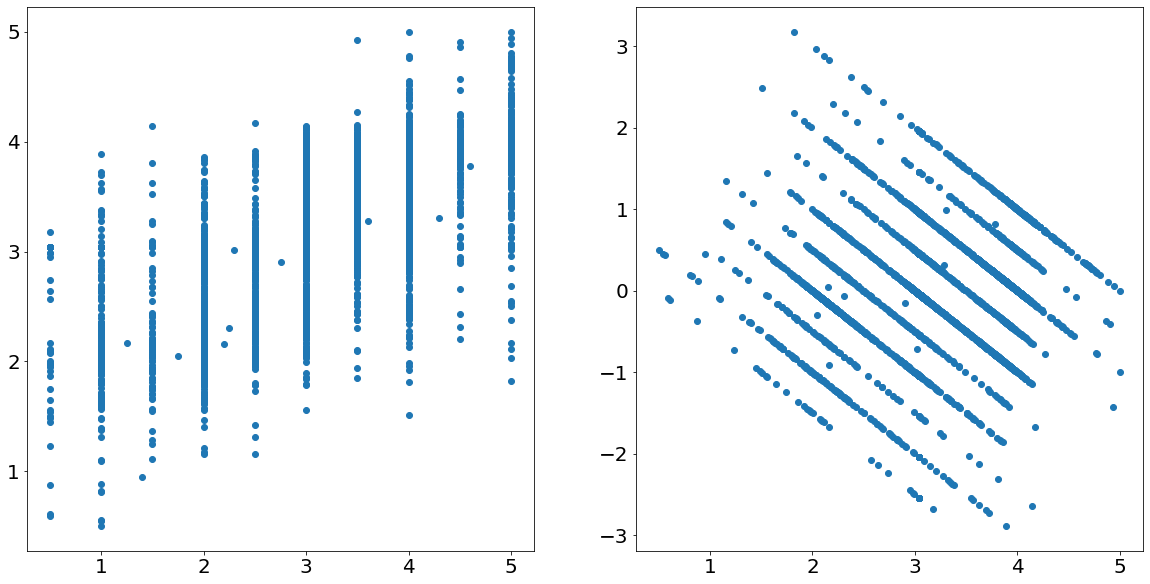

In [35]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(targets, preds)
plt.subplot(122)
diff = targets - preds
plt.scatter(preds, diff)
plt.show()

0.576006215372826
0.5609911406423035


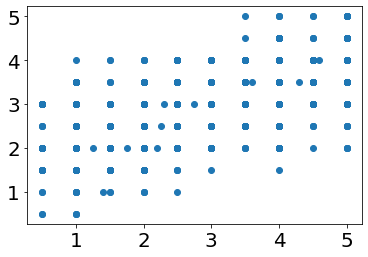

In [47]:
stars = np.linspace(0.5, 5, 10)
dists = np.abs((np.vstack([preds]*10)).T - stars)
best_guesses = stars[np.argmin(dists, axis=1)]
plt.scatter(targets, best_guesses)
print(np.abs(preds-targets).mean())
print(np.abs(best_guesses-targets).mean())